In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, LeaveOneOut, StratifiedKFold, cross_val_score, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [2]:
loan_approval = pd.read_csv('./archive/Loan.csv')
loan_approval.shape

(20000, 36)

In [3]:
loan_approval['ApplicationDate'] = pd.to_datetime(loan_approval['ApplicationDate'])
loan_approval['ApplicationYear'] = loan_approval['ApplicationDate'].dt.year
loan_approval['ApplicationMonth'] = loan_approval['ApplicationDate'].dt.month
loan_approval = loan_approval.drop(columns=['ApplicationDate'])  #

In [4]:
X = loan_approval.drop(columns=['LoanApproved', 'RiskScore'])
y = loan_approval['LoanApproved']

In [5]:
categorical_cols = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 
                    'HomeOwnershipStatus', 'LoanPurpose']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [6]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalize numerical data
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical data
    ])

In [7]:
X_preprocessed = preprocessor.fit_transform(X)

In [8]:
random_split = ShuffleSplit(n_splits=30, test_size=0.2)
kfold = KFold(n_splits=10, shuffle=True)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True)
loo = LeaveOneOut()

In [9]:
def scores_split(model, X, y, cv=None, test_size=None, feature_selection=False):
    selector = SelectKBest(f_classif, k=5)
    if cv is None:
        if test_size is None:
            print("Not Using Train-Test Split")
            X_train = X
            X_test = X
            y_train = y
            y_test = y
        else:
            print("Using Train-Test Split")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            # Apply feature selection only to training data
        if feature_selection:
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)  # Transform test set using the same selector
            
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred_test = model.predict(X_test)
        
        # Calculate and display performance metrics on the test set
        train_test_accuracy = accuracy_score(y_test, y_pred_test)
        train_test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        train_test_recall = recall_score(y_test, y_pred_test)
        train_test_roc = roc_auc_score(y_test, y_pred_test)
        
        print('Accuracy: ',train_test_accuracy)
        print('F1: ',train_test_f1)
        print('Recall: ', train_test_recall)
        print('ROC: ', train_test_roc)
        
        # Plot confusion matrix for the test set
        display = ConfusionMatrixDisplay.from_estimator(
                    model, X_test, y_test, display_labels=[0, 1],
                    cmap=plt.cm.Blues, normalize='true')
        display.ax_.set_title("Confusion Matrix (Test Data)")
        
        plt.show()

    else:
        print(f"Using Cross-Validation with {cv} folds")

        steps = []
        if feature_selection:
            steps.append(('feature_selection', selector))

        steps.append(('model', model))
        pipeline = Pipeline(steps)
        
        # Cross-validation scoring
        scores = ['accuracy', 'f1_weighted', 'recall_weighted', 'roc_auc']
        colors = ['r', 'g', 'b', 'm']  # Different colors for each metric
        metric_results = {}
        
        for score in scores:
            if feature_selection:
                X = selector.fit_transform(X, y)
            cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=score)
            metric_results[score] = cv_scores  # Store the cross-validation scores
            print(f'{score}: {cv_scores.mean()}')

        plt.figure()
        
        for i, metric in enumerate(scores):
            plt.plot(range(1, len(metric_results[metric]) + 1),
                     metric_results[metric], label=metric.capitalize(),
                     color=colors[i])
            
        plt.title(f"Cross-Validation Scores ({cv} folds)")
        plt.xlabel("Fold Number")
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

In [10]:
model = LogisticRegression(solver='liblinear')

Not Using Train-Test Split
Accuracy:  0.9665
F1:  0.9664442879807217
Recall:  0.9251046025104602
ROC:  0.9523026297703419


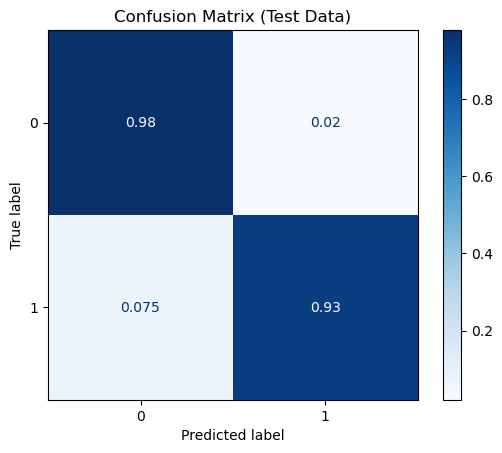

In [11]:
scores_split(model, X_preprocessed, y)

Using Train-Test Split
Accuracy:  0.964875
F1:  0.9648324513316104
Recall:  0.9215162840363054
ROC:  0.9498229371870771


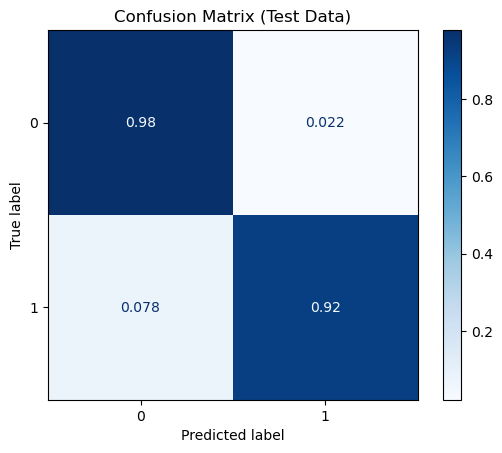

In [12]:
scores_split(model, X_preprocessed, y, test_size=0.4)

Using Cross-Validation with ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None) folds
accuracy: 0.9652416666666667
f1_weighted: 0.9657989753554829
recall_weighted: 0.9655499999999999
roc_auc: 0.9948969038639621


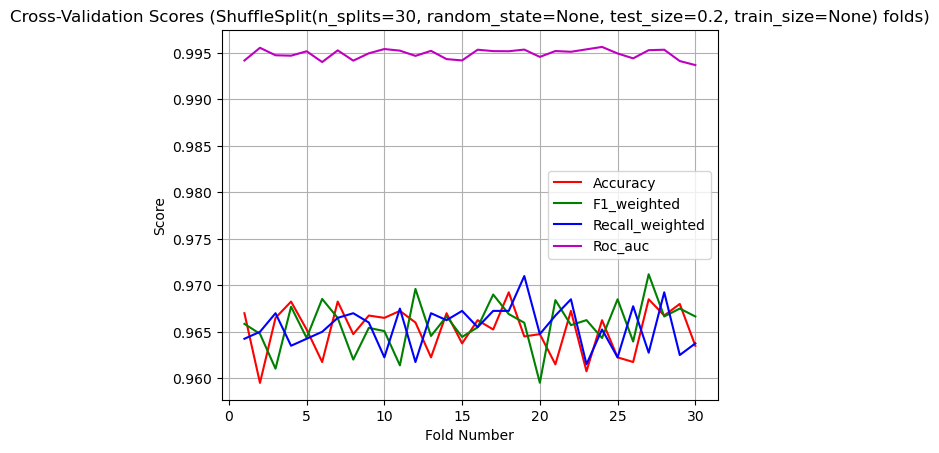

In [13]:
scores_split(model, X_preprocessed, y, cv=random_split)

Using Cross-Validation with KFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.9658000000000001
f1_weighted: 0.9654047753748694
recall_weighted: 0.96555
roc_auc: 0.994954392354192


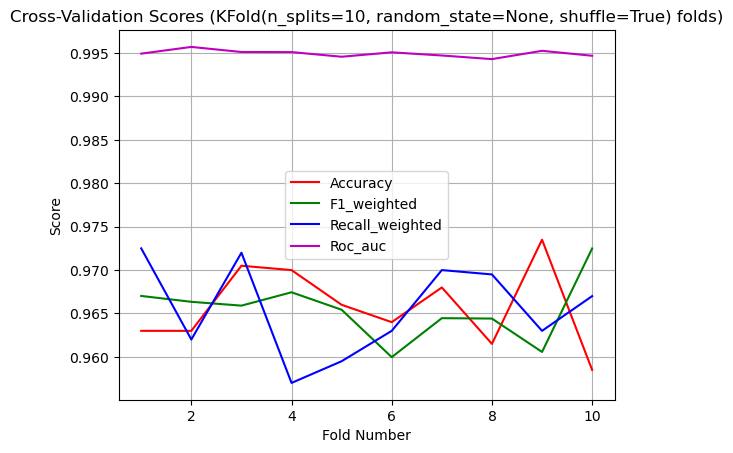

In [14]:
scores_split(model, X_preprocessed, y, cv=kfold)

Using Cross-Validation with StratifiedKFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.9653500000000002
f1_weighted: 0.9658913343838259
recall_weighted: 0.96585
roc_auc: 0.9949049917802496


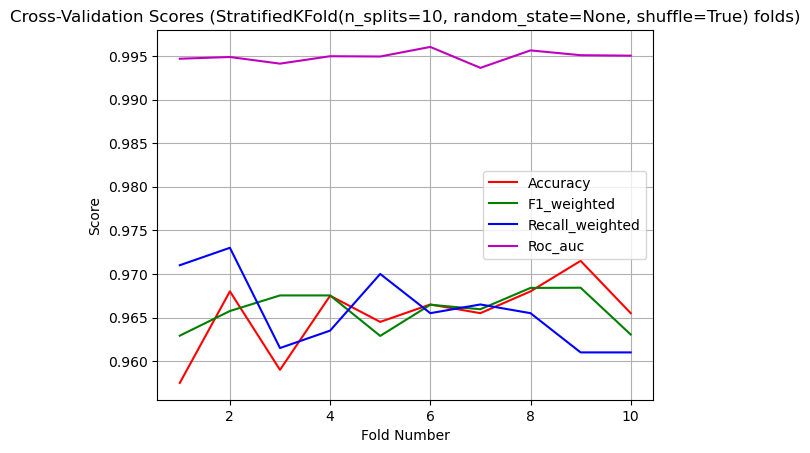

In [15]:
scores_split(model, X_preprocessed, y, cv=stratified_kfold)

In [16]:
# scores_split(model, X_preprocessed, y, cv=loo)

## Tests with Feature Selection

Not Using Train-Test Split
Accuracy:  0.89875
F1:  0.8972166382654947
Recall:  0.7468619246861925
ROC:  0.8466569807399424


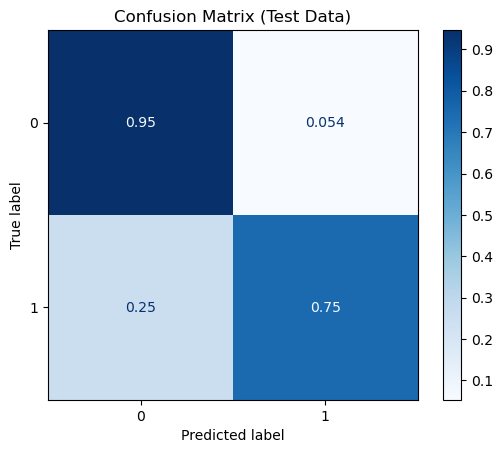

In [18]:
scores_split(model, X_preprocessed, y, feature_selection=True)

Using Train-Test Split
Accuracy:  0.899
F1:  0.8970278637924863
Recall:  0.7375259875259875
ROC:  0.8438288265477205


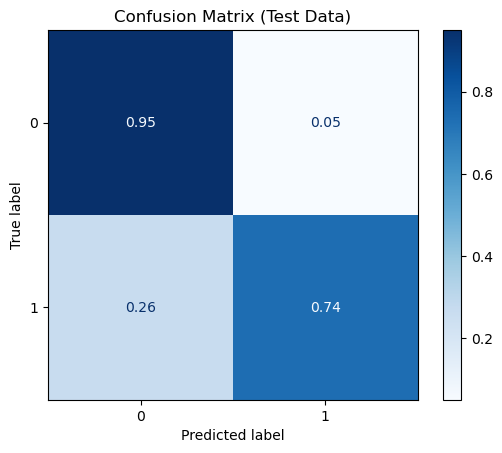

In [19]:
scores_split(model, X_preprocessed, y, test_size=0.4, feature_selection=True)

Using Cross-Validation with ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None) folds
accuracy: 0.8986166666666667
f1_weighted: 0.8975355279902897
recall_weighted: 0.8990916666666667
roc_auc: 0.9503735671170271


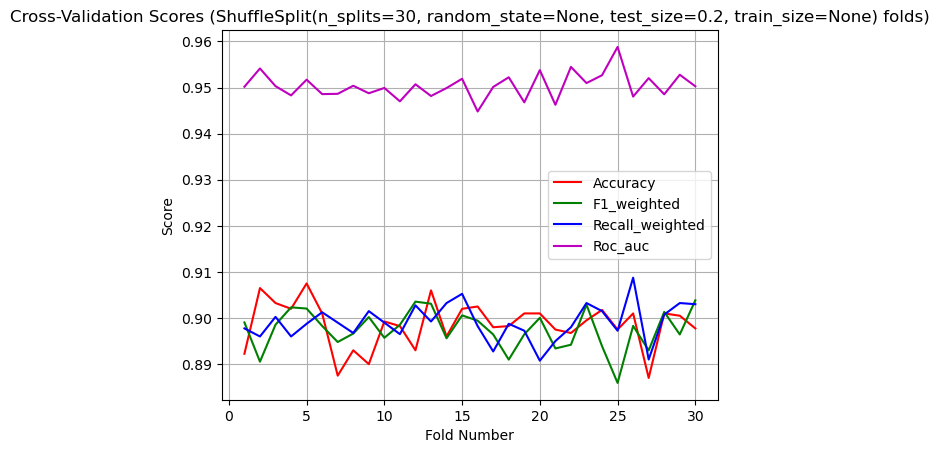

In [20]:
scores_split(model, X_preprocessed, y, cv=random_split, feature_selection=True)

Using Cross-Validation with KFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.8985999999999998
f1_weighted: 0.8968838674202168
recall_weighted: 0.8989
roc_auc: 0.9510767003747251


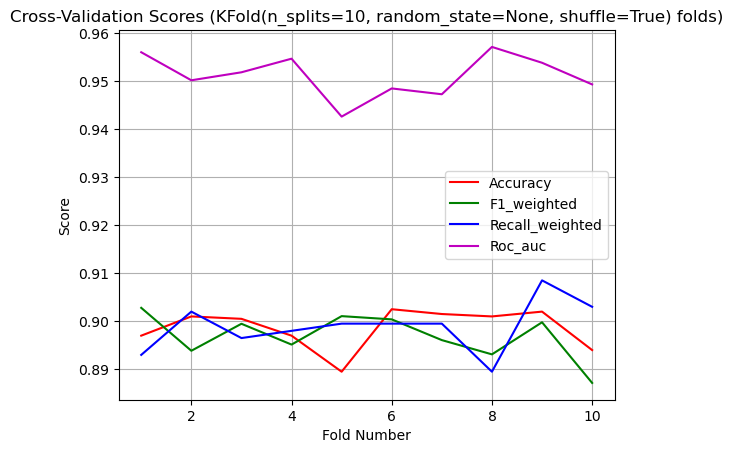

In [21]:
scores_split(model, X_preprocessed, y, cv=kfold, feature_selection=True)

Using Cross-Validation with StratifiedKFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.8988999999999999
f1_weighted: 0.8972000884524682
recall_weighted: 0.8985999999999998
roc_auc: 0.9509261651977413


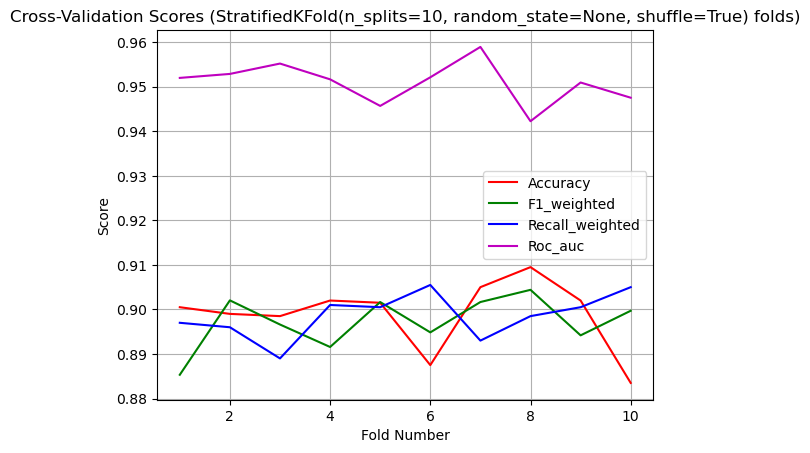

In [22]:
scores_split(model, X_preprocessed, y, cv=stratified_kfold, feature_selection=True)

In [23]:
# scores_split(model, X_preprocessed, y, cv=loo, feature_selection=True)